In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import re
import operator
import itertools


# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [2]:
#Loading the data 
data=pd.read_excel('Sample_Sales_Data.xlsx')

In [4]:
data.shape

(16136, 15)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16136 entries, 0 to 16135
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            16136 non-null  int64  
 1   Month                           16136 non-null  int64  
 2   Subcategory                     16136 non-null  object 
 3   Category                        16136 non-null  object 
 4   Model / Style Number            16136 non-null  object 
 5   Ordered Revenue                 16136 non-null  float64
 6   Ordered Revenue - % of Total    16136 non-null  float64
 7   Ordered Revenue - Prior Period  16136 non-null  object 
 8   Ordered Units                   16136 non-null  int64  
 9   Subcategory (Sales Rank)        15127 non-null  float64
 10  Glance Views                    16029 non-null  float64
 11  Change in Glance View - MOM     16029 non-null  object 
 12  Change in GV YOY                

In [6]:
#data.describe().T

In [ ]:
#Check for duplicate rows
print("Duplicate counnt", data.duplicated().sum())
data.loc[data.duplicated(keep=False),:]

In [8]:
data=data.drop_duplicates()

In [9]:
data.shape

(16128, 15)

In [10]:
data.nunique()

Year                                  2
Month                                12
Subcategory                          77
Category                             28
Model / Style Number               1394
Ordered Revenue                   11064
Ordered Revenue - % of Total      11047
Ordered Revenue - Prior Period    10831
Ordered Units                      1668
Subcategory (Sales Rank)           3096
Glance Views                       3787
Change in Glance View - MOM        7630
Change in GV YOY                   5855
Conversion Rate                    6719
LFO (Price)                        3515
dtype: int64

In [11]:
data.dtypes.value_counts()

object     6
float64    6
int64      3
dtype: int64

In [12]:
#Null value Columns
null_cols=data.columns[data.isna().any()]
null_cols

Index(['Subcategory (Sales Rank)', 'Glance Views',
       'Change in Glance View - MOM', 'Change in GV YOY', 'Conversion Rate',
       'LFO (Price)'],
      dtype='object')

In [13]:
#plt.scatter(data['Subcategory (Sales Rank)'],data['Category'])

In [14]:
data.isnull().sum()

Year                                 0
Month                                0
Subcategory                          0
Category                             0
Model / Style Number                 0
Ordered Revenue                      0
Ordered Revenue - % of Total         0
Ordered Revenue - Prior Period       0
Ordered Units                        0
Subcategory (Sales Rank)          1001
Glance Views                       107
Change in Glance View - MOM        107
Change in GV YOY                   107
Conversion Rate                   5101
LFO (Price)                       5396
dtype: int64

In [15]:
data.isnull().sum()/len(data)*100

Year                               0.000000
Month                              0.000000
Subcategory                        0.000000
Category                           0.000000
Model / Style Number               0.000000
Ordered Revenue                    0.000000
Ordered Revenue - % of Total       0.000000
Ordered Revenue - Prior Period     0.000000
Ordered Units                      0.000000
Subcategory (Sales Rank)           6.206597
Glance Views                       0.663442
Change in Glance View - MOM        0.663442
Change in GV YOY                   0.663442
Conversion Rate                   31.628224
LFO (Price)                       33.457341
dtype: float64

In [ ]:
#Data Preprocessing

In [16]:
#cr_null=data[data["Conversion Rate"].isnull()]
#cr_null[cr_null["Month"]!=1].head()

In [17]:
bool=data["Change in Glance View - MOM"].str.replace('\W', '0', regex=True)

In [18]:
bool.value_counts(dropna=False)

NaN    11076
0       5052
Name: Change in Glance View - MOM, dtype: int64

In [19]:
bool.isnull().sum()

11076

In [20]:
#data["Month"].value_counts(dropna=False)

Indexing with Time Series Data


In [21]:
df=data.copy()

In [22]:
df["Date"] = pd.to_datetime(df["Year"].astype('str') + "/" + df["Month"].astype('str'))

In [23]:
df["Date"].sample(3)

1419   2021-02-01
2597   2021-04-01
7461   2021-09-01
Name: Date, dtype: datetime64[ns]

In [24]:
#Indexing with Time Series Data
df = df.set_index('Date')
df.index

DatetimeIndex(['2021-01-01', '2021-01-01', '2021-01-01', '2021-01-01',
               '2021-01-01', '2021-01-01', '2021-01-01', '2021-01-01',
               '2021-01-01', '2021-01-01',
               ...
               '2022-06-01', '2022-06-01', '2022-06-01', '2022-06-01',
               '2022-06-01', '2022-06-01', '2022-06-01', '2022-06-01',
               '2022-06-01', '2022-06-01'],
              dtype='datetime64[ns]', name='Date', length=16128, freq=None)

In [25]:
df.head(3)

,Year,Month,Subcategory,Category,Model / Style Number,Ordered Revenue,Ordered Revenue - % of Total,Ordered Revenue - Prior Period,Ordered Units,Subcategory (Sales Rank),Glance Views,Change in Glance View - MOM,Change in GV YOY,Conversion Rate,LFO (Price)
Date,,,,,,,,,,,,,,,
2021-01-01,2021,1,Subcategory 070,Category 24,BE112230056,321270.0840,0.045487,-0.052463,80022,2.0,334355.0,-0.183714,1.548302,0.100755,0.000009
2021-01-01,2021,1,Subcategory 014,Category 05,WIZ0003ttBK,328651.1945,0.046532,0.109727,4123,2.0,89784.0,-0.132924,—,0.029125,0.000000
2021-01-01,2021,1,Subcategory 070,Category 24,BP112230056,329032.4535,0.046586,0.033723,1896,5.0,103721.0,0.175122,0.725922,0.056102,0.000060


In [26]:
#df['Ordered Revenue - Prior Period']=df['Ordered Revenue - Prior Period'].str.replace(r'\D+', '0', regex=True)


In [27]:
#df['Ordered Revenue - Prior Period']=df['Ordered Revenue - Prior Period'].fillna('0')
#df['Ordered Revenue - Prior Period']=df['Ordered Revenue - Prior Period'].astype('float')

Data consists of missing/null values and special characters: These need to be taken care of before proceeding with further analysis.

However, for primary analysis, I am only considering univariant time series analysis. As the required features (‘Year’, ‘Month’, ‘Order Revenue’) are free of null/ missing values moving ahead.


# Univariate time series

In [28]:
# Aggregate data based on Date(month) 

df_new =df.groupby(['Date'], as_index=True).agg({
                                                            
                                                             'Year':lambda x: x.unique(),
    
                                                             'Month':lambda x: x.unique(),
  
                                                             'Category':lambda x: x.unique(),

                                                             'Ordered Revenue' : lambda x: x.sum(),
                                                                
                                                             'Subcategory':lambda x: x.count(),
    
                                                             'Ordered Units': lambda x:x.sum(),
    
                                                             #'Ordered Revenue - Prior Period':lambda x: x.sum(),
                                
                                                             #'Glance Views': lambda x:x.sum()
                                                                
                                                              #'': lambda x:list(set(x.tolist())),
    
                                                              #'':lambda x:x.unique()
                                                                 })



In [29]:
df_new.head()

,Year,Month,Category,Ordered Revenue,Subcategory,Ordered Units
Date,,,,,,
2021-01-01,2021,1,"[Category 24, Category 05, Category 17, Catego...",7.062916e+06,851,306683
2021-02-01,2021,2,"[Category 24, Category 05, Category 17, Catego...",7.067403e+06,841,260541
2021-03-01,2021,3,"[Category 24, Category 17, Category 05, Catego...",6.380075e+06,875,215011
2021-04-01,2021,4,"[Category 24, Category 05, Category 17, Catego...",7.772300e+06,894,224396
2021-05-01,2021,5,"[Category 24, Category 05, Category 17, Catego...",6.089733e+06,887,231296


In [30]:
y = df_new['Ordered Revenue']#.resample('MS').mean()


In [31]:
y.sample(2)

Date
2021-08-01    8.714424e+06
2022-03-01    7.943414e+06
Name: Ordered Revenue, dtype: float64

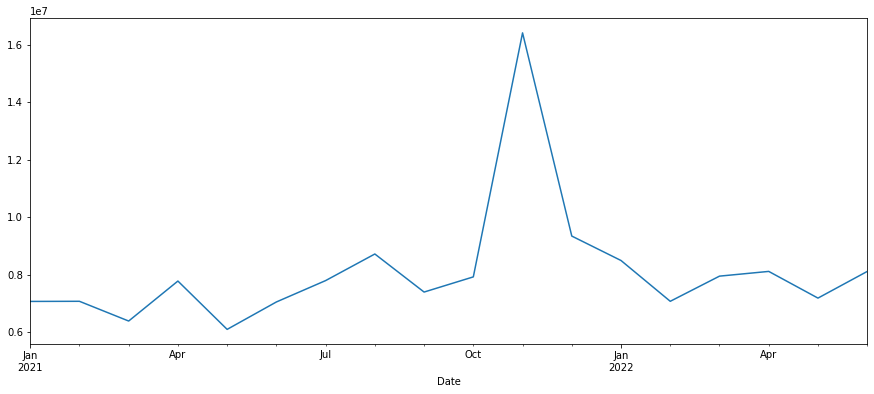

In [32]:
#distribution of sales
y.plot(figsize=(15, 6))
plt.show()

Time series decomposition: seasonality trend and residuals

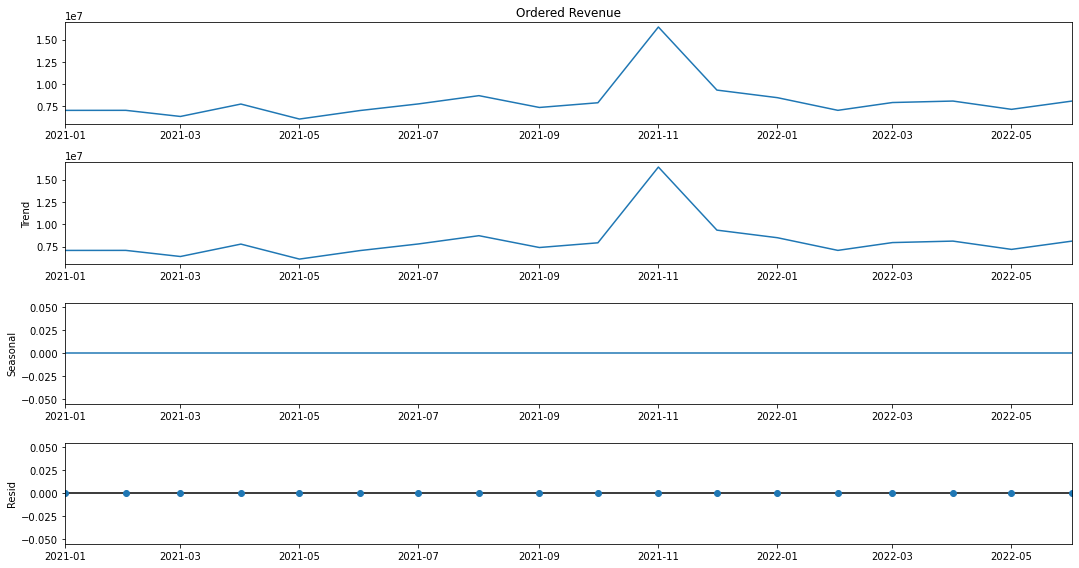

In [33]:
rcParams['figure.figsize'] = 15,8
decomposition = sm.tsa.seasonal_decompose(y,freq=1)
fig = decomposition.plot()
plt.show()

#Statistical tests to check stationarity in Time Series

In [34]:
def adf_test(ts):
    test_result = adfuller(ts)
    print ('ADF Test:')
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']

    for value,label in zip(test_result,labels):
        print (label+':'+str(value))
    if test_result [1] <= 0.05:
        print ("strong evidence against the null hypothesis(Ho), reject the null hypothesis and data is stationary")
    else:
        print ("weak evidence against null hypothesis, thereby data is non-stationary ")

In [35]:
adf_test(y)

ADF Test:
ADF Statistic:-2.4302004937317387
p-value:0.13339331225123296
No. of Lags Used:7
Number of Observations Used:10
weak evidence against null hypothesis, thereby data is non-stationary 


The data is non-stationary , need to apply differencing to make the data stationary.

### Differencing

In [36]:
df_new['Ordered Revenue First Diff'] =df_new['Ordered Revenue']-df_new['Ordered Revenue'].shift(1)


In [37]:
# Checking stationarity in Time Series after differencing
adf_test(df_new['Ordered Revenue First Diff'].dropna())

ADF Test:
ADF Statistic:-5.768996560937113
p-value:5.447731881364701e-07
No. of Lags Used:0
Number of Observations Used:16
strong evidence against the null hypothesis(Ho), reject the null hypothesis and data is stationary


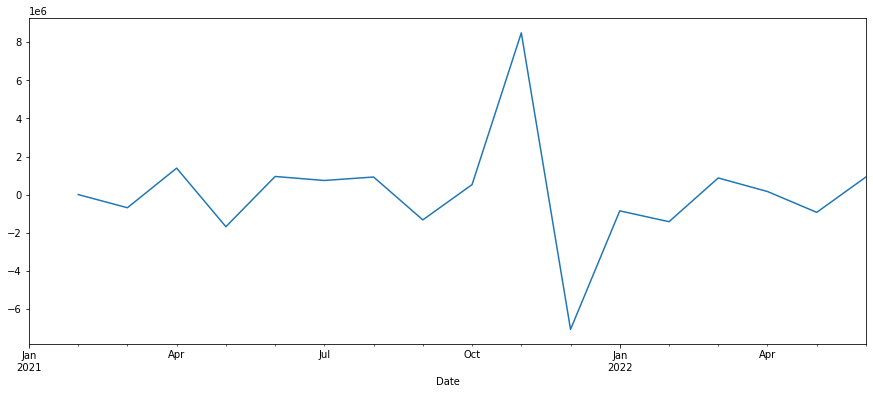

In [38]:
df_new['Ordered Revenue First Diff'].plot(figsize=(15, 6))
plt.show()

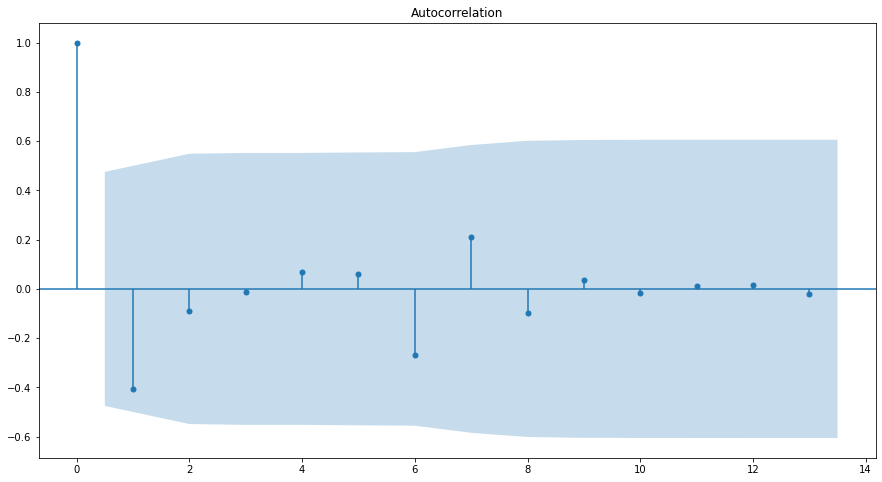

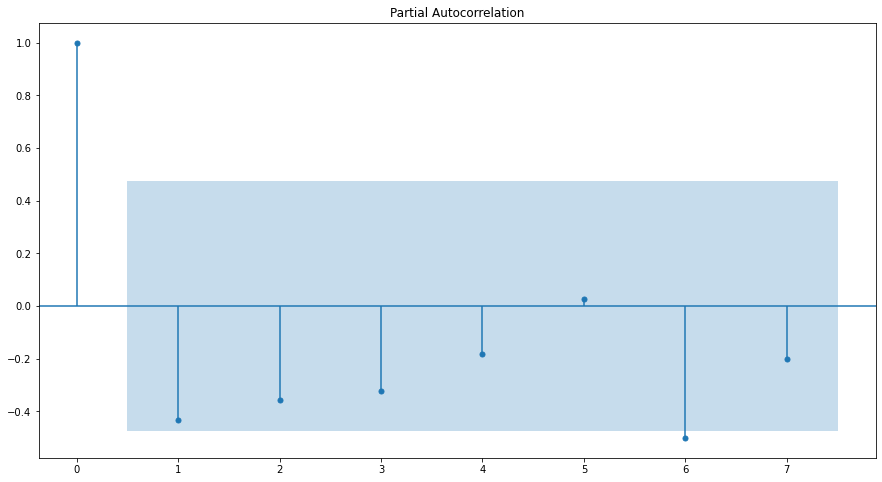

In [39]:
fig_first = plot_acf(df_new['Ordered Revenue First Diff'].dropna())

first_plot=plot_pacf(df_new['Ordered Revenue First Diff'].dropna(), lags=7)

#Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 13 must be < 8.

In [40]:
df_new.shape

(18, 7)

# Autoregressive Integrated Moving-Average

## Train / Test Split

In [41]:
train_data = df_new.iloc[0:14]
test_data = df_new.iloc[14:]

In [42]:
train_data.tail(2)


,Year,Month,Category,Ordered Revenue,Subcategory,Ordered Units,Ordered Revenue First Diff
Date,,,,,,,
2022-01-01,2022,1,"[Category 24, Category 05, Category 13, Catego...",8.487560e+06,897,360801,-8.508925e+05
2022-02-01,2022,2,"[Category 24, Category 05, Category 17, Catego...",7.067253e+06,885,252815,-1.420307e+06


In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
model=ARIMA(train_data['Ordered Revenue'],order=(1,1,0))
model_fit=model.fit()

In [45]:
print(model_fit.summary().tables[1])

                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     333.5639   6.07e+05      0.001      1.000   -1.19e+06    1.19e+06
ar.L1.D.Ordered Revenue    -0.3773      0.244     -1.545      0.122      -0.856       0.101


<AxesSubplot:xlabel='Date'>

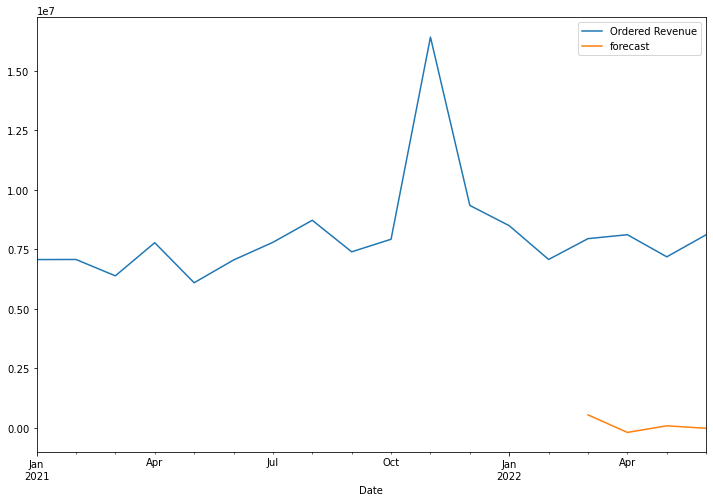

In [46]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
df_new['forecast']=model_fit.predict(start=start,end=end,dynamic=True)
df_new[['Ordered Revenue','forecast']].plot(figsize=(12,8))

In [47]:
df_new['forecast'].value_counts()

 536319.345893    1
-201885.562110    1
 76627.705003     1
-28451.032780     1
Name: forecast, dtype: int64

#SARIMA Trail
model_sar=sm.tsa.statespace.SARIMAX(train_data['Ordered Revenue'],order=(1, 1, 0),seasonal_order=(1,0,0,12))
results=model_sar.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()
df_new['forecast2']=results.predict(start=start-4,end=end,dynamic=True)
df_new[['Ordered Revenue','forecast2']].plot(figsize=(12,8))
from sklearn.metrics import mean_squared_error
from math import sqrt
test_data['Ordered Revenue'].mean()
rmse=sqrt(mean_squared_error(df_new['forecast2'][14:],test_data['Ordered Revenue']))
print(rmse)

==========================

ARIMA is not suitable for data - XGB regressor is one of the alternative choice

In [48]:
# Checking data and dropping unnecessary columns

In [49]:
df_new=df_new.drop(['forecast','Ordered Revenue First Diff'],axis=1)
df_new["Quarter"]=df_new.index.quarter # for better prediction 

In [50]:
df_new.sample(2)

,Year,Month,Category,Ordered Revenue,Subcategory,Ordered Units,Quarter
Date,,,,,,,
2021-03-01,2021,3,"[Category 24, Category 17, Category 05, Catego...",6.380075e+06,875,215011,1
2022-06-01,2022,6,"[Category 24, Category 05, Category 17, Catego...",8.106498e+06,918,313255,2


In [51]:
df_new.isnull().sum()

Year               0
Month              0
Category           0
Ordered Revenue    0
Subcategory        0
Ordered Units      0
Quarter            0
dtype: int64

In [52]:
train_data = df_new.iloc[0:14]
test_data = df_new.iloc[14:]

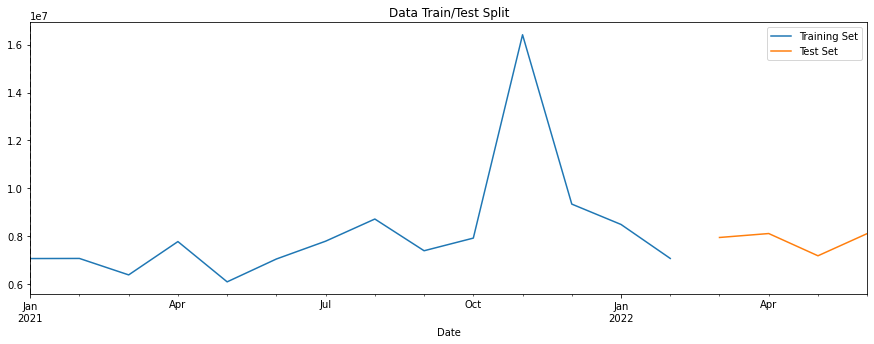

In [53]:
#series plot 
fig, ax = plt.subplots(figsize=(15, 5))
train_data['Ordered Revenue'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_data['Ordered Revenue'].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# XGBoost Regressor

In [54]:
#X_train, y_train, X_test, y_test for model training 

X_train = train_data[["Year","Quarter","Month"]]
y_train = train_data['Ordered Revenue']

X_test = test_data[["Year","Quarter","Month"]]
y_test = test_data['Ordered Revenue']

In [55]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=50,eval_metric='mae')

[0]	validation_0-mae:8104588.50000	validation_1-mae:7757836.00000
[50]	validation_0-mae:5071174.50000	validation_1-mae:4724421.00000
[100]	validation_0-mae:3283772.25000	validation_1-mae:3076695.00000
[150]	validation_0-mae:2187698.50000	validation_1-mae:2096825.62500
[200]	validation_0-mae:1525186.62500	validation_1-mae:1537753.87500
[250]	validation_0-mae:1138883.12500	validation_1-mae:1302157.87500
[300]	validation_0-mae:862589.43750	validation_1-mae:1101805.62500
[350]	validation_0-mae:677321.50000	validation_1-mae:944089.37500
[400]	validation_0-mae:580886.81250	validation_1-mae:821123.87500
[450]	validation_0-mae:508085.59375	validation_1-mae:723984.37500
[500]	validation_0-mae:449193.93750	validation_1-mae:656927.50000
[550]	validation_0-mae:391882.46875	validation_1-mae:652214.50000
[560]	validation_0-mae:381559.43750	validation_1-mae:652348.00000


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [56]:
#
test_data['prediction'] = reg.predict(X_test)
df_new = df_new.merge(test_data[['prediction']], how='left', left_index=True, right_index=True)


In [57]:
df_new.prediction


Date
2021-01-01          NaN
2021-02-01          NaN
2021-03-01          NaN
2021-04-01          NaN
2021-05-01          NaN
2021-06-01          NaN
2021-07-01          NaN
2021-08-01          NaN
2021-09-01          NaN
2021-10-01          NaN
2021-11-01          NaN
2021-12-01          NaN
2022-01-01          NaN
2022-02-01          NaN
2022-03-01    7262961.5
2022-04-01    7439481.0
2022-05-01    6836082.0
2022-06-01    7195950.0
Name: prediction, dtype: float32

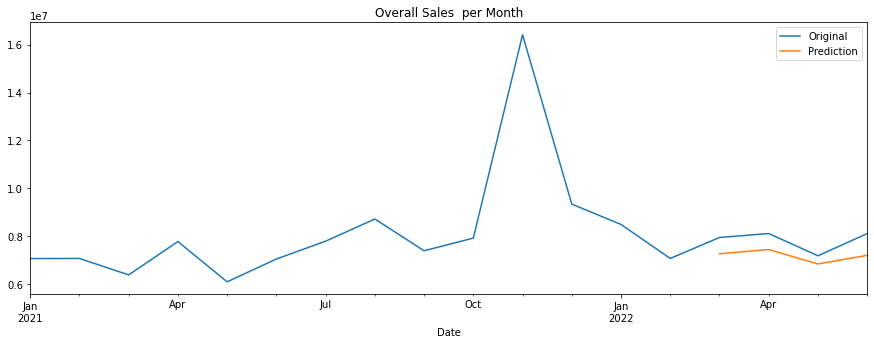

In [58]:
#prediction plot
ax = df_new.loc[(df_new.index > '2020-12-01') & (df_new.index < '2022-07-01')]['Ordered Revenue'] \
    .plot(figsize=(15, 5), title='Overall Sales  per Month')
df_new.loc[(df_new.index > '2020-12-01') & (df_new.index < '2022-07-01')]['prediction'] \
    .plot()
plt.legend(['Original','Prediction'])
plt.show()

In [59]:
#score
score = np.sqrt(mean_squared_error(test_data['Ordered Revenue'], test_data['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 681291.79


In [60]:
#Error calculation
test_data['error'] = np.abs(test_data['Ordered Revenue'] - test_data['prediction'])
test_data['date'] = test_data.index.date
test_data.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-06-01    910548.393171
2022-03-01    680452.504708
2022-04-01    668685.311029
2022-05-01    342607.620775
Name: error, dtype: float64

In [61]:
#New data frame for forecast
from pandas.tseries.offsets import DateOffset
future_dates=[df_new.index[-1]+ DateOffset(months=x)for x in range(0,13)]

In [62]:
xgb_df=pd.DataFrame(index=future_dates[1:],columns=df_new.columns)

In [63]:
df_forc=pd.concat([df_new,xgb_df])

In [64]:
df_forc.tail(2)

,Year,Month,Category,Ordered Revenue,Subcategory,Ordered Units,Quarter,prediction
2023-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
#Populating new DF 
df_forc['Year']=df_forc.index.year
df_forc['Month']=df_forc.index.month
df_forc["Quarter"]=df_forc.index.quarter

In [66]:
#predict :next 12 months of overall sales using time-series analysis 

df_forc['prediction_forc'] = reg.predict(df_forc[['Year',"Quarter",'Month']])
#df_new = df_new.merge(test_data[['prediction']], how='left', left_index=True, right_index=True)

In [67]:
df_forc.head(2)

,Year,Month,Category,Ordered Revenue,Subcategory,Ordered Units,Quarter,prediction,prediction_forc
2021-01-01,2021,1,"[Category 24, Category 05, Category 17, Catego...",7.062916e+06,851,306683,1,NaN,7270814.0
2021-02-01,2021,2,"[Category 24, Category 05, Category 17, Catego...",7.067403e+06,841,260541,1,NaN,6884217.0


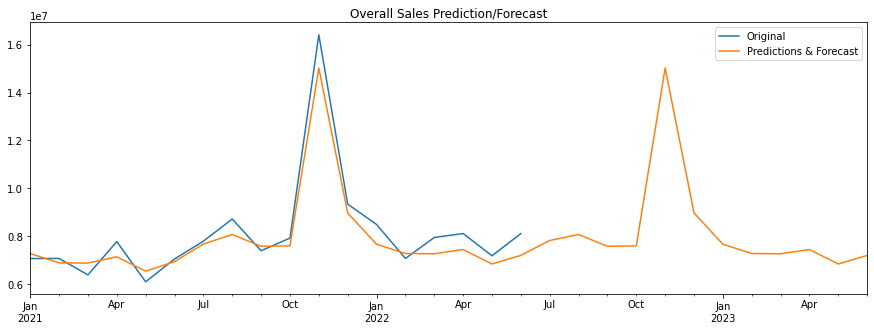

In [68]:
#Forecasting :next 12 months of overall sales 
ax = df_forc[['Ordered Revenue']].plot(figsize=(15, 5))
df_forc['prediction_forc'].plot(ax=ax)
plt.legend(['Original', 'Predictions & Forecast'])
ax.set_title('Overall Sales Prediction/Forecast')
plt.show()